In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label, binary_dilation, binary_closing, binary_fill_holes, binary_dilation
from skimage.measure import regionprops

In [16]:
# Load behavioral trial data (push onset times)
df_behavior = pd.read_excel("calcium_imaging_behavioral_trials.xlsx")

# Load ROI mask and extract pixel-to-brain-region mapping
df_roi = pd.read_csv("roi_idx.csv")

# Load multiple trial datasets and check shape consistency
trial_files = ["trial_1.csv", "trial_2.csv", "trial_3.csv", "trial_4.csv", "trial_5.csv",
              "trial_6.csv", "trial_7.csv", "trial_8.csv", "trial_9.csv", "trial_10.csv"]  # Update if needed
df_trials = [pd.read_csv(trial, header=None) for trial in trial_files]

In [17]:
# Ensure all trials have the same shape
min_time_bins = min(df.shape[1] for df in df_trials)  # Find shortest trial
df_trials = [df.iloc[:, :min_time_bins] for df in df_trials]  # Trim to same length

# Compute the average calcium signal across trials (ignoring NaNs)
df_trial_avg = pd.concat(df_trials).groupby(level=0).mean()

# Define constants
sampling_rate = 30  # Hz
pixel_size = 64  # 64x64 pixels
num_time_bins = df_trial_avg.shape[1]  # Total available time bins

# Compute total available recording time
total_recording_time = num_time_bins / sampling_rate

# Extract push onset time and ensure it is within range
push_time = df_behavior.iloc[0]["onset_push"] if "onset_push" in df_behavior.columns else None
if push_time is None:
    raise ValueError("Column 'onset_push' not found in behavioral data.")

# Cap push time if it's too high
push_time = min(push_time, total_recording_time - 2)

In [21]:
# Define time points relative to push onset
time_offsets = [-1.0, 0, 0.5, 1.0, 2.0]  # Before, during, and after push onset
time_labels = ["-1.0s", "Push Onset", "+0.5s", "+1.0s", "+2.0s"]

# **Shift push bin by 1 second (30 frames)**
corrected_push_bin = max(int(push_time * sampling_rate) - 30, 0)  # Shift forward by 30 frames

# **Compute corrected time bins (Ensure all bins exist in dataset)**
time_bins = [
    max(min(corrected_push_bin + int(offset * sampling_rate), num_time_bins - 1), 0)
    for offset in time_offsets
]

# **Debugging: Print the new push bin and time bins**
print(f"New Corrected Push Bin: {corrected_push_bin}")
print(f"Updated Time Bins: {time_bins}")


New Corrected Push Bin: 158
Updated Time Bins: [128, 158, 173, 188, 218]


In [22]:
roi_mask = np.zeros((pixel_size, pixel_size))
for i, row in df_roi.iterrows():
    roi_pixels = row[1:].dropna().astype(int).values  # Get valid pixel indices
    roi_mask[np.unravel_index(roi_pixels, (pixel_size, pixel_size))] = i + 1  # Assign unique index

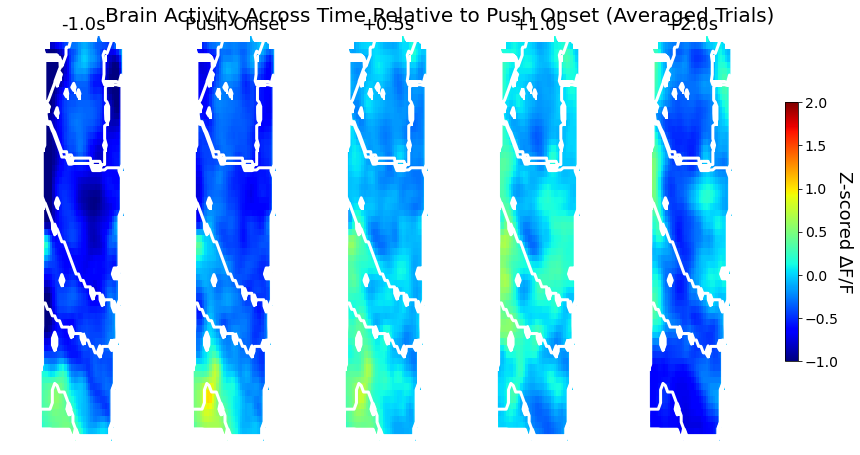

In [33]:
# **Better Figure Size**
fig, axes = plt.subplots(1, 5, figsize=(12, 6))

# Define fixed color scale
vmin, vmax = -1, 2  

# Generate plots for each time point
for idx, (time_bin, label) in enumerate(zip(time_bins, time_labels)):
    if time_bin >= num_time_bins:
        print(f"Skipping {label}, time_bin {time_bin} is out of range.")
        continue

    # Extract brain activity data
    brain_activity = df_trial_avg.iloc[:, time_bin].values.reshape((pixel_size, pixel_size))
    brain_activity = np.nan_to_num(brain_activity)  # Replace NaNs
    brain_activity = gaussian_filter(brain_activity, sigma=1.0)  # Smoothing

    # Create subplot
    ax = axes[idx]

    # **Ensure No Extra Background**
    ax.set_facecolor("none")  # Remove any background color

    # **Ensure Proper Aspect Ratio**
    ax.set_aspect('auto')

    # **Larger Heatmap Without Extra Space**
    img = sns.heatmap(
        brain_activity,
        cmap="jet",  
        cbar=False,  
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        mask=(roi_mask == 0),  
        square=False,  # Avoid forced padding
        xticklabels=False,  # Remove axis labels
        yticklabels=False
    )

    # **Overlay ROI Boundaries**
    ax.contour(roi_mask, colors="white", linewidths=3)

    ax.set_title(label, fontsize=18)
    ax.axis("off")

# **Reduce Space Between Plots Even More**
plt.subplots_adjust(wspace=0.001)  # Remove almost all space

# **Remove Extra White Padding**
plt.tight_layout(pad=0)  # Fully removes excess padding

# **Adjust Color Bar to Avoid Overlapping**
fig.subplots_adjust(right=0.88)  # Keep color bar properly positioned
cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])  # Adjust size
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap="jet", norm=norm)

# **Enhance Color Bar Labeling**
cbar.set_label("Z-scored ∆F/F", fontsize=18, rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=14)

# **Final Title & Layout**
plt.suptitle("Brain Activity Across Time Relative to Push Onset (Averaged Trials)", fontsize=20, y=1.02)
plt.show()
